# Unsupervised Learning Lab

In this lab you will work through several examples of methods and applications of unsupervised learning. We will be working with the **Digits** dataset of of handwritten numbers. This dataset is convenient because Scikit-learn provides it built-in.

**NOTE**: I do not explicitly *ask* for your analyses in this notebook, but you should definitely provide them!

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

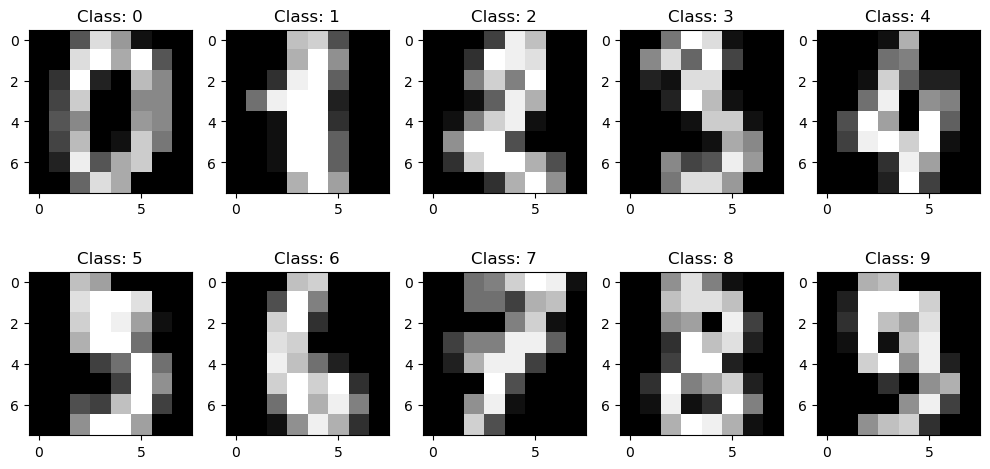

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the digits dataset and extract data and labels.
ds_digits = load_digits()
Xs = ds_digits.data
ys = ds_digits.target

scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)

# Create a pandas DataFrame 'df_digits' to hold the dataset's features.
# Note: This dataset doesn't have column names as it represents image pixel values.
df_digits = pd.DataFrame(ds_digits.data)

# Create a pandas Series 'targets_digits' to store the target labels of the dataset.
targets_digits = pd.Series(ds_digits.target)

# Print the description of the dataset using 'DESCR' attribute of 'ds_digits'.
print(ds_digits['DESCR'])

# Print the statistical summary of the features in the dataset using 'describe' method of 'df_digits'.
print(df_digits.describe())

# Access and print the column names (feature names) of the dataset using 'feature_names' attribute of 'ds_digits'.
column_names = ds_digits['feature_names']
print(column_names)

# Create a 5x5 grid of subplots with a defined figure size
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Plot the 10 classes and their corresponding labels in the dataset
for i in range(10):
    row = i // 5  # Determine the row position (0 to 4)
    col = i % 5   # Determine the column position (0 to 4)

    # Display the image using grayscale colormap
    axes[row, col].imshow(ds_digits.images[i], cmap='gray')

    # Set the title for the subplot with the image label
    axes[row, col].set_title(f"Class: {ds_digits.target[i]}")

# Adjust the spacing between subplots for better layout
plt.tight_layout()

# Display the subplots
plt.show()

## 1. Clustering
In this set of exercises we will experiment with clustering of the digits dataset. One use of unsupervised techniques like K-Means Clustering is to use the discovered cluster structure to *induce* a classifier.  

### Exercise 1.1: K-means clustering
Use K-means clustering to cluster the digits dataset into 10 clusters (i.e. the "*correct*" number of clusters). After clustering the data, for each cluster center compute the sum-of-squared-distances to it and all points assigned to its cluster. This is called the cluster *inertia* and is a measure of cluster compactness.

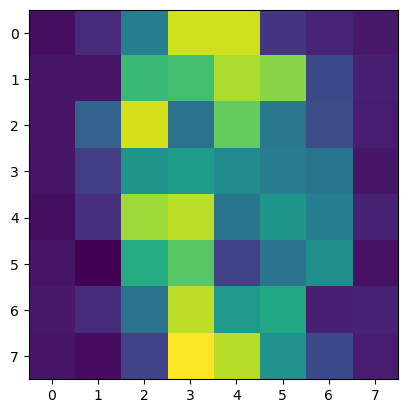

In [2]:
from scipy.spatial.distance import cdist  

def kmeans(Xs, K = 10, num_iter = 1000):
    (N, D) = Xs.shape
    means = 2.0 * np.random.rand(K, D) - 1.0
    for i in range(num_iter):
        #compute cluster assignments.
        I = np.argmin(cdist(Xs, means), 1)
        
        new_means = np.vstack([np.mean(Xs[I == c], 0) for c in range (K)])  
        
    I = np.argmin(cdist(Xs, means), 1)    
    return (means, np.argmin(cdist(Xs, means), 1))  

        
(means, I) = kmeans(Xs)
I
means = scaler.inverse_transform(means)


plt.imshow(means[5].reshape(8, 8))



Inertia per cluster:
Cluster 0: 5186.72
Cluster 1: 2962.47
Cluster 2: 5767.28
Cluster 3: 9052.58
Cluster 4: 13260.88
Cluster 5: 8136.22
Cluster 6: 3322.59
Cluster 7: 12500.90
Cluster 8: 3896.07
Cluster 9: 5320.36

The minimum inertia is 2962.47 for cluster number 1


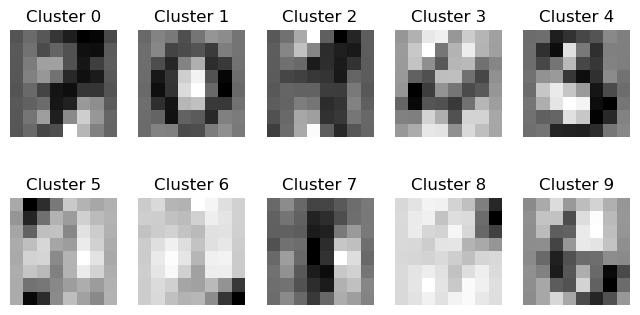

In [3]:
from sklearn.cluster import KMeans # try silhouette score -- inertia sucks

# Perform K-means clustering with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42, n_init=100)
kmeans.fit(Xs)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_ # The actual centroids    
labels = kmeans.labels_

inertia_per_cluster = np.zeros(10)
for i in range(10):
    cluster_points = Xs[labels == i]
    inertia_per_cluster[i] = np.sum((cluster_points - cluster_centers[i]) ** 2)

# Print the results
print("\nInertia per cluster:")
for i, inertia in enumerate(inertia_per_cluster):
    print(f"Cluster {i}: {inertia:.2f}")

print(f"\nThe minimum inertia is {inertia_per_cluster.min():.2f} for cluster number {inertia_per_cluster.argmin()}")

# Visualize the cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(cluster_centers[i].reshape(8, 8), cmap='binary')
    axi.set_title(f"Cluster {i}")
    axi.axis('off')

plt.show()



**COOL:**
In the context of the K-means algorithm applied to the digits dataset, each centroid would represent the average pixel values of the digits within a particular cluster.

### Exercise 1.2: Transforming our clustering into a classifier
Now use the labels in `ys` to compute a probability distribution over all classes (i.e. a *histogram*) for each cluster. Write a function that, given a test sample $\mathbf{x}$, returns the class with maximum likelihood given by the closest cluster center. Evaluate your classifier. Compute the entropy for each cluster based on your estimated probability distributiont. Does the entropy of a cluster correlate to misclassifications of test samples closest to it?

**Note**: since you will be testing this classifier, you will want to carefully split the data into *training* and *test* splits.

In [4]:
"""from sklearn.model_selection import train_test_split

(Xs_train, Xs_test, ys_train, ys_test) = train_test_split(Xs, ys, test_size=0.5, shuffle = True)
(means, I) = kmeans(Xs_train, K = 10)

for c in range(10):
    plt.figure(figsize=(9, 2))
    plt.hist(ys_train[I == c], bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])"""

'from sklearn.model_selection import train_test_split\n\n(Xs_train, Xs_test, ys_train, ys_test) = train_test_split(Xs, ys, test_size=0.5, shuffle = True)\n(means, I) = kmeans(Xs_train, K = 10)\n\nfor c in range(10):\n    plt.figure(figsize=(9, 2))\n    plt.hist(ys_train[I == c], bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])'

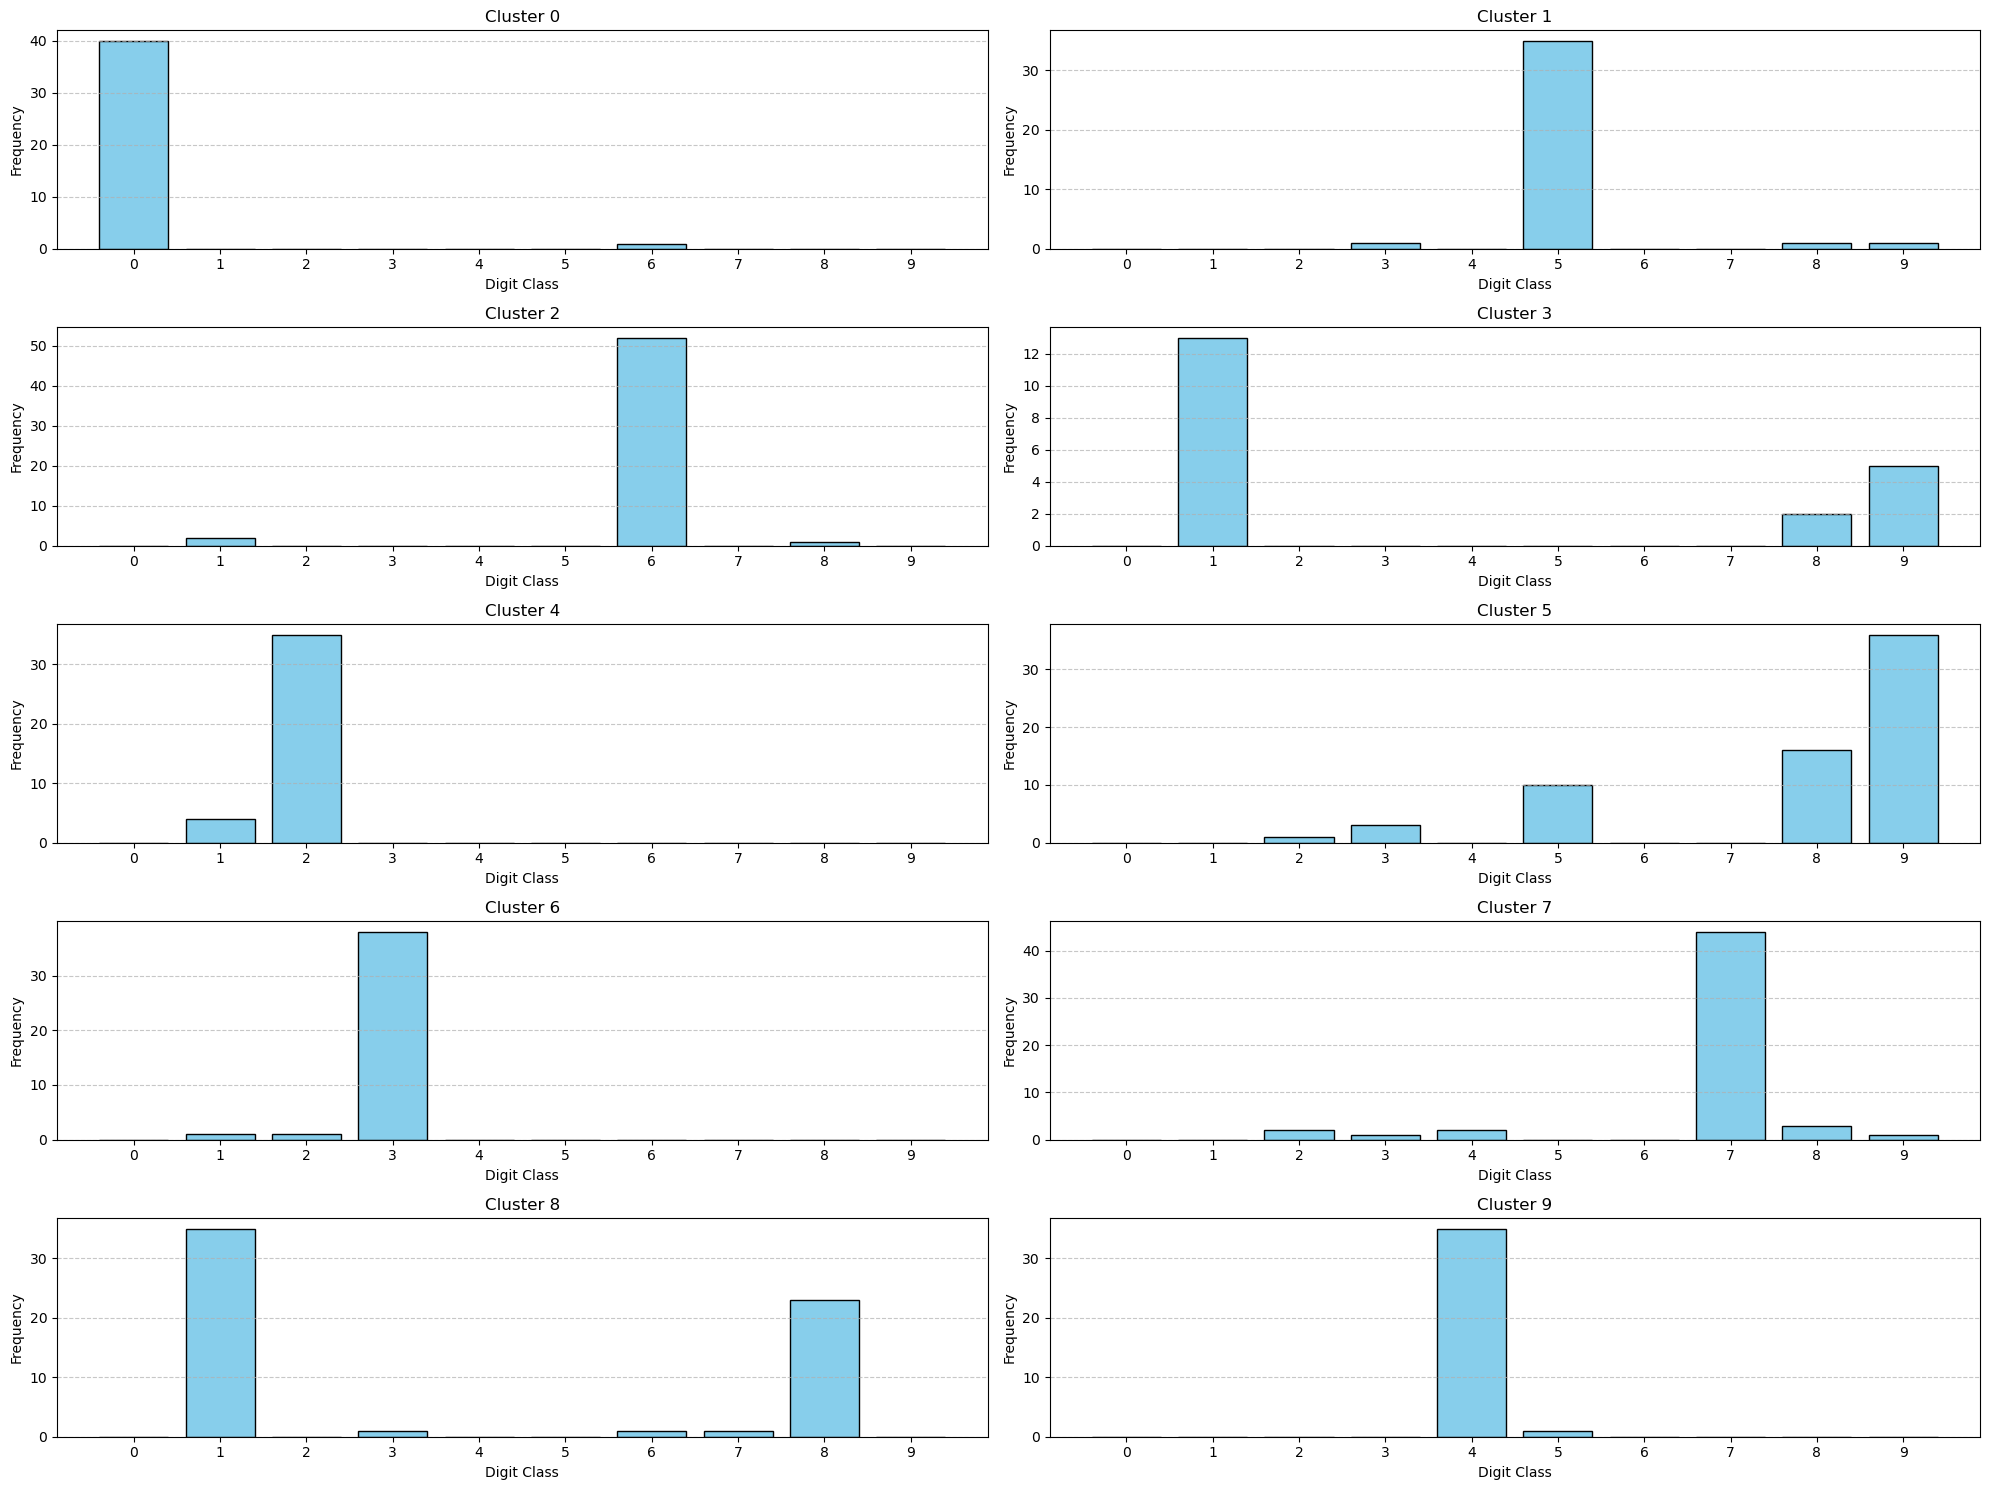

In [5]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(df_digits, targets_digits, test_size=0.75)

kmeans.fit(Xtr)
cluster_labels = kmeans.predict(Xtr)

# Function to plot histograms for each cluster
def plot_cluster_histograms(cluster_labels, true_labels):
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)

    # Define the number of rows and columns for subplots
    rows = (num_clusters + 1) // 2  # Ensure an even number of subplots in each row
    cols = 2

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

    for i, cluster_id in enumerate(unique_clusters):
        mask = (cluster_labels == cluster_id)
        cluster_classes = true_labels[mask]

        # Determine subplot position
        if rows > 1:
            ax = axes[i // cols, i % cols]
        else:
            ax = axes[i]
        # Plot histogram for the current cluster
        ax.hist(cluster_classes, bins=np.arange(11) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Digit Class')
        ax.set_ylabel('Frequency')
        ax.set_xticks(range(10))
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and show the subplots
    plt.tight_layout()
    plt.show()

# Example: Plot histograms for each cluster
plot_cluster_histograms(cluster_labels, ytr)


In [6]:
import numpy as np

class KMClassifier:
    def __init__(self, K = 10, num_classes = 10):
        self.K_ = K
        self.model_ = KMeans(n_clusters=K)
        self.num_classes = num_classes
        
    def fit(self, Xs, yx):
        self.model_.fit(Xs)
        self.labels_ = []
        for c in range(self.K_):
            assigned = ys[self.model_.labels_ == c]
            self.labels_.append(np.array([(assigned == cls).sum() for cls in range(self.num_classes)]))
        self.labels_ = np.argmax(np.vstack(self.labels_), 1)  
        
    def predict(self, Xs):
        D = cdist(Xs, self.model_.cluster_centers_)
        return self.labels_[np.argmin(D, 1)]
        
        
model = KMClassifier()
model.fit(Xs, ys)
(model.predict(Xs) == ys).mean()

/Users/pampaj/anaconda3/envs/FML/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.6221480244852532

In [7]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(Xs, ys)
(svc.predict(Xs) == ys).mean()

/Users/pampaj/anaconda3/envs/FML/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/pampaj/anaconda3/envs/FML/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9944351697273233

## 2. Gaussian Mixture Models and Expectation Maximization
In this set of exercises we will experiment with fitting a Gaussian Mixture Model (GMM) to the digits dataset.  

### Exercise 2.1: Fitting a GMM
Fit a GMM (using `sklearn.mixture.GaussianMixture`) with 10 mixture components to the digits dataset. 

In [8]:
# Your code here.
from  sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(Xs)

GaussianMixture(n_components=10)

In [9]:
gmm.predict_proba(Xs).shape
gmm.weights_

array([0.08736541, 0.09961046, 0.11787014, 0.10016694, 0.13938014,
       0.0651088 , 0.01669449, 0.09739122, 0.0523094 , 0.224103  ])

### Exercise 2.2: Transforming the GMM into a classifier
Use the `predict_proba()` method of your fit GMM to obtain the probability distribution over the mixture components for all samples in the training set. Use these, together with the true labels `ys`, to construct a classifier as above with K-means. Evaluate your classifier. Repeat the experiment with more mixture components.

In [10]:
# Your code here.
#normalize + plot

### Exercise 2.3: Sampling from the GMM
Use the `sample()` method on a GMM fit to the digits data to generate random samples from the learned distribution. Visualize these samples in the original feature space. Are there some digits better reconstructed than others? How might you determine *which* ones are better captured?

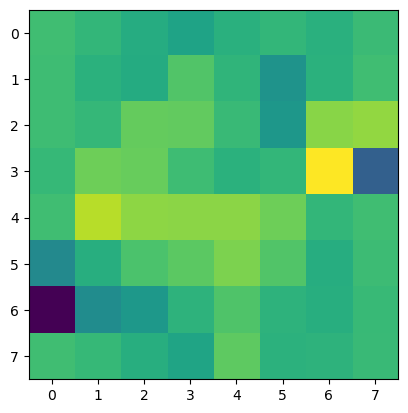

In [11]:
# Your code here.
from scipy.stats import multivariate_normal
foo = multivariate_normal(gmm.means_[0], gmm.covariances_[0])
sample = foo.rvs()
plt.imshow(sample.reshape(8, 8))

## 3. Principal Component Analysis
In this set of exercises we will see how Principal Component Analysis (PCA) can be used to *simplify* the representation of input data in order to make visualize them or to make learning more stable. 

### Exercise 3.1: Fitting a Bayesian Generative Model

Fit a *Quadratic* generative model (e.g. `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()`) to the Digits dataset. Observe *all* warnings that the model fitting procedure returns. How well does the trained model work?

**Note**: Since we are using a *supervised* model as a downstream task, you should *split* the dataset into training and test sets. 

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

qdc = QuadraticDiscriminantAnalysis()
qdc.fit(Xs, ys)
(qdc.predict(Xs) == ys).mean()

/Users/pampaj/anaconda3/envs/FML/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.9081803005008348

## Exercise 3.2: Removing "redundant" dimensions

Use *Principal Component Analysis (PCA)* to reduce the dimensionality of the digits dataset. You can use `sklearn.decomposition.PCA` for this. You should think carefully about how to choose the *number* of principal components to use. You should also think *very carefully* about which data is used to estimate the principal components. Use the transformed dataset to train and test a Bayes Quadratic classifier.

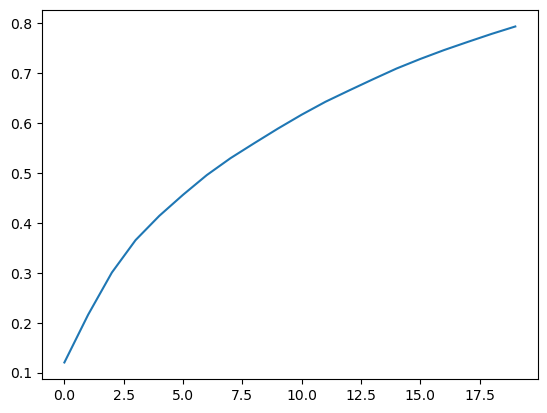

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
Xs_trans = pca.fit_transform(Xs)
Xs_trans.shape
plt.plot(np.cumsum(pca.explained_variance_ratio_))

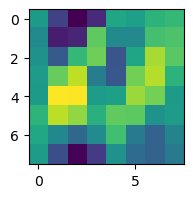

In [14]:
qdc.fit(Xs_trans, ys)
(qdc.predict(Xs_trans) == ys).mean() ## good improvment 
plt.figure(figsize = (2, 3)); plt.imshow(pca.components_[0].reshape(8, 8))

### Exercise 3.3: PCA as a visualization tool

Transform the Digits dataset onto only *two* dimensions and visualize the dataset using a scatterplot. You can use `ys` to *color* the points in the scatterplot according to the true classes. Do the classes form natural clusters? Do some of them?

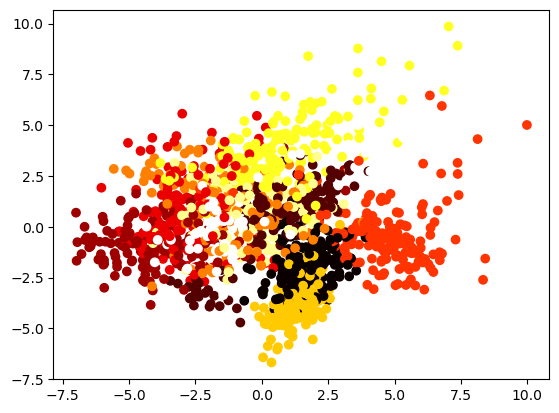

In [15]:

plt.scatter(Xs_trans[:, 0], Xs_trans[:, 1], c = ys, cmap='hot')

### Exercise 3.4: TSNE for *better* visualization
PCA is severely limited by the fact that it finds a *linear* manifold of the original data. Use `sklearn.manifold.TSNE` instead to learn a 2-dimensional *nonlinear* manifold of digits. Repeat the visualization like before.